# Versionamento

V2: 
<ul>
    <li>Inclusão da variável categórica x28 que está relacionada com o tipo de papel em produção</li>
    <li>Feature Selection</li>
    <li>Feature Scalling</li>
</ul>

V3:
<ul>
    <li>Ajuste de parâmetros dos modelos</li>
    <li> V2: correção da função lstm_data_transform para pegar o target correto</li>
</ul>

V4:
<ul>
    <li>Redução de feature usando resultado do PCA (notebook DimRedPCAOnTS) </li>
</ul>

V5:
<ul>
    <li>Uso de dataset separado manualmente para treino e teste separado do de validação </li>
    <li>num_steps de 30 para 10</li>
    <li>Verificação do comportamento das features entre uma quebra e a próxima</li>
</ul>

# O problema

Paper manufacturing can be viewed as a continuous rolling process. During this process, sometimes the paper breaks. If a break happens, the entire process is stopped, the reel is taken out, any found problem is fixed, and the production is resumed. The resumption can take more than an hour.

The cost of this lost production time is significant for a mill. Even a 5% reduction in the break events will give a significant cost saving for a mill. The objective of the given problem is to predict such breaks in advance (early prediction) and identify the potential cause(s) to prevent the break. 

To build such a prediction model, we will use the data collected from the network of sensors in a mill.

This is a multivariate time series data with break as the response (a
binary variable).
The provided data has,
<ul>
    <li>18,398 records.</li>
    <li>Columns:</li>
        <ul>
        <li>time: the timestamp of the row</li>
        <li>y: the binary response variable. There are only 124 rows with y = 1, rest are y = 0.</li>
        <li>x1-x61: predictor variables. All the predictors are continuous variables, except x28 and x61. x61 is a binary variable, and x28 is a
        categorical variable. All the predictors are centered. Besides, the predictors are a mixture of raw materials and process variables. Their descriptions are omitted for data anonymity.
            Several sensors are placed in different parts of the machine along its length
and breadth. These sensors measure both raw materials (e.g. amount of pulp
fiber, chemicals, etc.) and process variables (e.g. blade type, couch vacuum,
rotor speed, etc.).</li>
        </ul>
</ul>

# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import datetime

# Load Data

In [2]:
pwbdatafile = '..\\data\\pwb-data-augmented.csv'
pwbds = pd.read_csv(pwbdatafile)

In [3]:
pwbds.head()

,Unnamed: 0,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x53,x54,x55,x56,x57,x58,x59,x60,x61,timestamp
0,0,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0,0
1,1,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0,1
2,2,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0,2
3,3,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0,3
4,4,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0,4


In [4]:
pwbds.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
pwbds.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x53,x54,x55,x56,x57,x58,x59,x60,x61,timestamp
0,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,...,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0,0
1,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,...,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0,1
2,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,...,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0,2
3,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,...,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0,3
4,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,...,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0,4


In [6]:
# Now, the target
pwbds.y.value_counts()

0    52538
1      363
Name: y, dtype: int64

## Cálculo do Remaining Usefull Lifecycle (RUL)

In [7]:
# Dates whith break
df_sub = sorted(pwbds[pwbds['y'] == 1]['timestamp'].tolist())

In [8]:
df_sub

[259,
 776,
 835,
 1036,
 1263,
 1301,
 1339,
 1344,
 1719,
 1750,
 2121,
 2298,
 2303,
 2308,
 2312,
 2317,
 2335,
 2366,
 2374,
 2378,
 2407,
 2591,
 2599,
 2645,
 2714,
 2738,
 2826,
 2921,
 2945,
 2963,
 2971,
 2999,
 3522,
 3598,
 3600,
 3748,
 4018,
 4177,
 4797,
 4933,
 5457,
 6220,
 6823,
 7147,
 7173,
 7243,
 7609,
 7843,
 7939,
 7946,
 8022,
 8072,
 8083,
 8130,
 8221,
 8236,
 8475,
 8933,
 9101,
 9148,
 9153,
 9196,
 9203,
 9412,
 9431,
 9523,
 9842,
 10037,
 10163,
 10241,
 10798,
 10817,
 10837,
 10893,
 11152,
 11503,
 11551,
 11574,
 11743,
 11751,
 11792,
 11829,
 11867,
 12324,
 13081,
 13614,
 14029,
 14138,
 14160,
 14516,
 14914,
 15096,
 15294,
 15413,
 15436,
 15456,
 15483,
 15520,
 15526,
 15531,
 15567,
 15590,
 15644,
 15647,
 15663,
 15669,
 15705,
 15709,
 15739,
 15770,
 15806,
 15926,
 16259,
 16693,
 16923,
 17033,
 17182,
 17205,
 17293,
 17476,
 17605,
 17758,
 18282,
 18601,
 18737,
 18743,
 18831,
 19015,
 19245,
 19427,
 19483,
 19488,
 20108,
 20631

In [9]:
# variable to store all days
breakSubIdx=0
breakLstIdx=0
breakList = pwbds['y'].tolist()
nextbreak = []
for v1 in pwbds['timestamp'].tolist():
    if((breakList[breakLstIdx] == 1)):
#        print ('1')
        nextbreak.append(v1)
        breakSubIdx = breakSubIdx+1
    else:
#        print('0')
        if (breakSubIdx < len(df_sub)):
            nextbreak.append(df_sub[breakSubIdx])
        else:
            nextbreak.append(df_sub[breakSubIdx-1])
    breakLstIdx = breakLstIdx+1
pwbds['nextbreaktime'] = pd.Series(nextbreak)

In [10]:
pwbds.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x54,x55,x56,x57,x58,x59,x60,x61,timestamp,nextbreaktime
0,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,...,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0,0,259
1,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,...,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0,1,259
2,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,...,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0,2,259
3,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,...,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0,3,259
4,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,...,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0,4,259


In [11]:
pwbds['RUL']=(pwbds['nextbreaktime']-pwbds['timestamp'])
#pwbds.drop(pwbds[pwbds.RUL < 0].index, inplace=True)
pwbds.drop(['timestamp','nextbreaktime'], axis=1, inplace=True)

In [12]:
pwbds.iloc[257:262,]

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x53,x54,x55,x56,x57,x58,x59,x60,x61,RUL
257,0,1.005602,-3.876199,-1.074373,0.844397,-0.553050,14.738228,0.000732,-0.061114,-0.030057,...,-0.752385,-5.015364,-69.553891,70.500879,4.050182,0.031596,3.746714,0.007695,0,2
258,0,0.933933,-3.868467,-1.249954,2.875311,-0.500941,15.643990,0.000732,-0.061114,-0.030057,...,-0.752385,-5.015458,-75.298153,68.812829,3.473400,0.032007,4.712130,0.007679,0,1
259,1,0.892311,-13.332664,-10.006578,2.855933,-0.448832,15.986336,0.000732,-0.061114,-0.030057,...,-0.752385,-5.015553,-75.896664,69.585016,3.113292,0.032223,5.685793,0.007663,1,0
260,0,0.020062,-3.987897,-1.248529,-72.927591,0.956625,-52.225319,0.000732,-0.061114,-0.030057,...,-14.211369,-5.159890,-96.241513,-10.347296,5.853832,0.023872,5.635012,0.006604,0,516
261,0,-0.109346,-5.071100,-2.409911,-68.501153,0.008764,-49.642799,0.000732,-0.061114,-0.030057,...,-14.153996,-5.159059,-67.912900,-4.702612,5.975902,0.021971,5.245829,0.006588,0,515


### Verificando cálculo do RUL

In [13]:
pwbds[pwbds.y==1]

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x53,x54,x55,x56,x57,x58,x59,x60,x61,RUL
259,1,0.892311,-13.332664,-10.006578,2.855933,-0.448832,15.986336,0.000732,-0.061114,-0.030057,...,-0.752385,-5.015553,-75.896664,69.585016,3.113292,0.032223,5.685793,0.007663,1,0
776,1,-0.782471,-12.118747,-16.855194,-322.781610,-0.738810,25.966042,0.040711,-0.071186,0.012574,...,-5.337590,2.680329,-7.209775,-37.195777,1.642284,0.013798,2.664362,0.007856,0,0
835,1,-0.697450,-1.696176,4.145142,121.152838,-0.598597,-7.789024,0.060853,0.048752,-0.120087,...,-6.368351,2.568616,-26.245907,-74.477362,-0.097279,0.015905,2.700281,0.007745,0,0
1036,1,-0.791718,-0.076644,-1.012134,162.257269,-0.062876,9.005471,0.005767,0.033764,-0.120087,...,-6.856144,2.703874,-29.833432,-53.421866,-1.165393,0.019691,3.348276,0.006241,0,0
1263,1,-1.212083,-2.326809,0.922287,31.935858,-0.920100,14.183205,-0.089298,0.028915,-0.120087,...,-6.856144,2.762956,0.965763,-49.512961,-0.219349,0.041640,2.740404,0.005131,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52626,1,-0.367076,-8.876281,-9.826331,-81.548181,0.719656,-31.805839,-0.058545,-0.000993,0.009922,...,10.091365,3.105512,101.055728,-59.396201,-2.111499,0.001227,1.458925,0.018978,0,0
52630,1,0.381548,-7.119146,-7.791697,-68.089395,0.172140,-61.932670,0.000732,-0.101094,0.009922,...,5.405574,-5.013181,-46.756772,-52.525641,-0.860218,0.016202,3.409899,0.007643,0,0
52708,1,0.386066,-9.029249,-8.759439,83.883705,-0.509745,52.357521,0.180791,0.268791,0.139931,...,1.914363,3.143712,18.257755,-72.250327,-1.775806,-0.149790,-0.102720,0.000803,1,0
52892,1,-0.082568,-8.880742,-16.979639,61.011024,-0.183390,26.041847,-0.059389,-0.091023,-0.040129,...,3.983455,-4.996303,-31.832699,54.449090,3.473400,0.011233,1.377375,0.007596,0,0


In [14]:
pwbds.iloc[257:262,][['y','RUL']]

,y,RUL
257,0,2
258,0,1
259,1,0
260,0,516
261,0,515


In [15]:
pwbds.drop(pwbds[pwbds.RUL < 0].index, inplace=True)

In [16]:
pwbds.iloc[257:262,][['y','RUL']]

,y,RUL
257,0,2
258,0,1
259,1,0
260,0,516
261,0,515


In [17]:
pwbds.head(100)

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x53,x54,x55,x56,x57,x58,x59,x60,x61,RUL
0,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,...,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0,259
1,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,...,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0,258
2,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,...,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0,257
3,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,...,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0,256
4,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,...,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0.338822,-5.022894,-2.608153,-20.503778,-0.017481,-44.553459,0.020874,-0.051043,-0.059966,...,-0.199894,-5.000089,-37.394345,-6.514594,4.434703,0.029854,1.558092,0.006878,0,164
96,0,0.308304,-5.194098,-2.751440,-19.194543,0.008062,-46.399620,0.020874,-0.051043,-0.059966,...,-0.204289,-5.000183,-42.467709,-7.359717,3.473400,0.029434,0.888880,0.006887,0,163
97,0,0.308107,-5.090988,-2.761078,-19.517114,0.033590,-47.134178,0.020874,-0.051043,-0.059966,...,-0.208684,-5.000278,-49.438046,-3.726843,3.473400,0.029229,1.255404,0.006896,0,162
98,0,0.336788,-5.116952,-2.638822,-20.037836,0.059133,-47.633186,0.020874,-0.051043,-0.059966,...,-0.213078,-5.000372,-39.797299,-3.818945,3.973888,0.029696,2.018366,0.006905,0,161


### Remove Break Avalanche

In [18]:
def removeBreakAvalanche (fullds):
    clean_ds = pd.DataFrame([])
    breaks = np.array(np.where(pwbds['y'] == 1)).reshape(-1)
    start = 0 
    for breakpt in breaks:
        if (breakpt-start >= 30):
            clean_ds = clean_ds.append(fullds.iloc[start:breakpt+1,],ignore_index = True)
        start = breakpt+1
    return (clean_ds)

In [19]:
clean_ds = removeBreakAvalanche(pwbds)

# Feature Selection and Scaling

In [20]:
# Feature Selection
# List of considered Features

FEATURES = [
    'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20',
    'x21','x22','x23','x24','x25','x26','x27','x28','x29','x30','x31','x32','x33','x34','x35','x36','x37','x38','x39','x40',
    'x41','x42','x43','x44','x45','x46','x47','x48','x49','x50','x51','x52','x53','x54','x55','x56','x57','x58','x59','x60'
#]
# Redução de feature usando resultado do PCA (notebook DimRedPCAOnTS)
#    'x1','x5','x8','x10','x13','x14','x15','x17','x18','x19','x20','x21','x22','x26','x28','x30','x31','x34',
#    'x35','x37','x38','x40','x41','x43','x46','x48','x49','x51','x53','x54','x55','x58'

# Usando as features com base na sua relação com RUL
#    'x4','x24','x48','x58','x60','x42','x45','x61','x46','x49','x9','x10','x38','x17','x5','x28','x33','x41',   
#    'x13','x16','x56','x8','x12','x1','x57','x50','x44','x47','x52','x27','x37','x3','x54','x26','x2','x29','x55'

# Cj 1 - Não usar: derrubou métricas quando adicionado ao Cj 4 + Cj 6
#    'x1','x2','x4','x5','x6','x7','x10', 'x11','x13','x15','x17','x28',
#    'x1','x5','x10','x13','x14','x15',
    
# Cj 2
# Medidos sem C3:
#    'x3','x8','x10','x12','x13','x16','x18','x19','x20','x23','x25', # Precision: 0.781, Recall: 0.390, F1: 0.520
#    'x3','x8','x10','x12','x13','x16',                               # Precision: 0.834, Recall: 0.375, F1: 0.518
#    'x18','x19','x20','x23','x25',                                   # Precision: 0.980, Recall: 0.156, F1: 0.269
#    'x3','x8','x10','x18','x19','x20',                               # Precision: 0.848, Recall: 0.251, F1: 0.387
#    'x12','x13','x16','x23','x25',                                   # Precision: 0.900, Recall: 0.218, F1: 0.351
# Medidos com C3:
###    'x3','x8','x10','x12','x13','x16','x18','x19','x20','x23','x25',  # Precision: 0.735, Recall: 0.470, F1: 0.573

    # Cj 3
###   'x9','x21','x22','x24','x26','x27','x29','x30',                   # Precision: 0.735, Recall: 0.470, F1: 0.573
#    'x9','x21','x22','x24',                                          # Precision: 0.785, Recall: 0.451, F1: 0.573
#    'x26','x27','x29','x30',                                         # Precision: 0.766, Recall: 0.406, F1: 0.530
#    'x9','x21','x29','x30',                                          # Precision: 0.742, Recall: 0.353, F1: 0.478
#    'x22','x24','x26','x27',                                          # Precision: 0.801, Recall: 0.383, F1: 0.518   
    
# Cj 4
###    'x28','x36','x37','x38','x39','x40','x31','x32','x33','x34','x35',
    
# Cj 5
#    'x41','x42','x43','x44','x45','x46','x47','x48','x49','x52',

# Cj 6
###   'x50','x51','x53','x54','x55','x56','x57','x58','x59','x60'
]

# Create the dataset with features and filter the data to the list of FEATURES
pwbds_filtered = clean_ds[FEATURES]

# Print the tail of the dataframe
pwbds_filtered.tail()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
51207,-0.151683,-3.954797,-4.299529,62.011024,-0.096552,25.731026,-0.059389,-0.091023,-0.030057,0.001791,...,27.413823,11.055832,4.041316,-4.996629,-31.080624,60.825372,4.114269,0.011547,1.405894,0.007603
51208,-0.186095,-4.056258,-4.205272,58.932471,-0.118266,25.050453,-0.059389,-0.091023,-0.040129,-0.001682,...,27.467778,11.113205,4.026912,-4.996548,-31.341977,58.203699,4.114269,0.011469,0.341051,0.007601
51209,-0.141189,-3.946290,-4.257756,64.271431,-0.139964,25.380898,-0.059389,-0.091023,-0.040129,-0.008280,...,27.521489,11.170578,4.012264,-4.996466,-31.505551,55.582056,3.473400,0.011390,0.110140,0.007599
51210,-0.163747,-6.551871,-6.632444,62.363684,-0.161677,25.711373,-0.059389,-0.091023,-0.040129,-0.008280,...,27.575444,11.227951,3.997859,-4.996385,-31.669125,54.916864,4.175304,0.011312,0.718683,0.007598
51211,-0.082568,-8.880742,-16.979639,61.011024,-0.183390,26.041847,-0.059389,-0.091023,-0.040129,-0.008280,...,27.629399,11.280441,3.983455,-4.996303,-31.832699,54.449090,3.473400,0.011233,1.377375,0.007596


In [21]:
# This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from sklearn.preprocessing import RobustScaler, MinMaxScaler 

# Get the number of rows in the data
nrows = pwbds_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(pwbds_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)
pwbds_scaled = pd.DataFrame(
    np_data_scaled,
    columns=FEATURES
)
pwbds_scaled['RUL'] = clean_ds['RUL']

(51212, 60)


# Shaping & Splitting

In [22]:
def lstm_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        
        # if index is larger than the size of the dataset, we stop
        if end_ix > x_data.shape[0]:
            break
        
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix-1]
        
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

## Dataset for Model 1

In [23]:
pwbds_m1 = pwbds_scaled.copy()
#pwbds_m1.drop('NEXT_H',axis='columns', inplace=True)
yds_m1 = pwbds_m1.pop('RUL')

## Apply PCA

In [24]:
from sklearn.decomposition import PCA # for PCA calculation
pca = PCA()
X_pca = pca.fit(pwbds_m1)

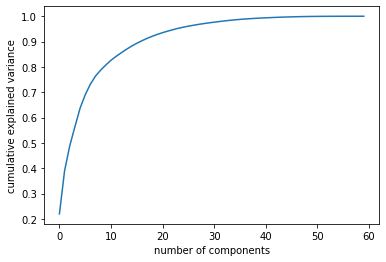

In [25]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [26]:
num_components = 40
pca = PCA(num_components)  
X_pca = pca.fit_transform(pwbds_m1) # fit and reduce dimension

In [27]:
X_pca.shape

(51212, 40)

In [28]:
num_steps = 5 # Intervalo entre medições é de 2 segundos
x_new, y_new = lstm_data_transform(X_pca, yds_m1, num_steps=num_steps)
print ("The new shape of x is", x_new.shape)

The new shape of x is (51208, 5, 40)


In [29]:
train_ind = int(0.7 * clean_ds.shape[0])
x_train = x_new[:train_ind]
y_train = y_new[:train_ind]
x_test = x_new[train_ind:]
y_test = y_new[train_ind:]

# Modeling 1: Regression - Predict RUL

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

C:\Users\hcord\anaconda3\envs\paper3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hcord\anaconda3\envs\paper3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hcord\anaconda3\envs\paper3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hcord\anaconda3\envs\paper3\lib\site-packages\tensorflow\pyth

In [31]:
print(tf. __version__)
print(np. __version__)
from platform import python_version

print(python_version())

1.14.0
1.19.5
3.6.9


In [32]:
model_1 = keras.Sequential()
model_1.add(layers.Bidirectional(layers.LSTM(120, activation='tanh', input_shape=(num_steps, x_train.shape[2]), 
               return_sequences=True)))
model_1.add(layers.BatchNormalization())

# Plus a 20% dropout rate
model_1.add(layers.Dropout(0.2))

# The second layer
model_1.add(layers.Bidirectional(layers.LSTM(units=60,return_sequences=False)))
model_1.add(layers.BatchNormalization())

# Plus a 20% dropout rate
model_1.add(layers.Dropout(0.2))
model_1.add(layers.Dense(units=60, activation='relu'))
model_1.add(layers.Dropout(0.2))
model_1.add(layers.Dense(units=30, activation='relu'))
model_1.add(layers.Dropout(0.2))
model_1.add(layers.Dense(units=1, activation='linear'))

# With adam optimizer and a binary crossentropy loss. We will opimize for model accuracy.
adam = keras.optimizers.Adam(lr=0.0001)
adagrad = keras.optimizers.Adagrad(learning_rate=0.0001,initial_accumulator_value=0.1, epsilon=1e-07)
rmsprop = keras.optimizers.RMSprop(learning_rate=0.0001,rho=0.9, momentum=0.001, epsilon=1e-07)

model_1.compile(optimizer=adam, loss='mse', metrics=['mse'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [33]:
# EarlyStopping Callback
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history_m1 = model_1.fit(
    x_train, 
    y_train, 
    epochs=60,
    callbacks=[callback],
#    batch_size=60, 
    validation_split=0.10 # Use 10% of data to evaluate the loss. (val_loss)
)

Train on 32263 samples, validate on 3585 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/60
32263/32263 [==============================] - 25s 773us/sample - loss: 38758.2843 - mean_squared_error: 38758.2930 - val_loss: 9403.8333 - val_mean_squared_error: 9403.8330
Epoch 2/60
32263/32263 [==============================] - 21s 661us/sample - loss: 11964.0147 - mean_squared_error: 11964.0088 - val_loss: 6273.7728 - val_mean_squared_error: 6273.7729
Epoch 3/60
32263/32263 [==============================] - 22s 689us/sample - loss: 8705.6578 - mean_squared_error: 8705.6553 - val_loss: 4707.6608 - val_mean_squared_error: 4707.6602
Epoch 4/60
32263/32263 [==============================] - 21s 655us/sample - loss: 7353.4153 - mean_squared_error: 7353.4146 - val_loss: 3836.7523 - val_mean_squared_error: 3836.7532
Epoch 5/60
32263/32263 [==============================] - 22s 686us/sample - loss: 6378.1443 - mean_squared_error: 6378.1

32263/32263 [==============================] - 22s 679us/sample - loss: 2576.3542 - mean_squared_error: 2576.3545 - val_loss: 660.0664 - val_mean_squared_error: 660.0662
Epoch 44/60
32263/32263 [==============================] - 22s 681us/sample - loss: 2519.9448 - mean_squared_error: 2519.9434 - val_loss: 692.6546 - val_mean_squared_error: 692.6546
Epoch 45/60
32263/32263 [==============================] - 22s 689us/sample - loss: 2425.6783 - mean_squared_error: 2425.6777 - val_loss: 719.9932 - val_mean_squared_error: 719.9933
Epoch 46/60
32263/32263 [==============================] - 22s 696us/sample - loss: 2440.3054 - mean_squared_error: 2440.3042 - val_loss: 627.8658 - val_mean_squared_error: 627.8657
Epoch 47/60
32263/32263 [==============================] - 22s 685us/sample - loss: 2397.0848 - mean_squared_error: 2397.0852 - val_loss: 618.9244 - val_mean_squared_error: 618.9243
Epoch 48/60
32263/32263 [==============================] - 23s 698us/sample - loss: 2465.1201 - mean_s

In [34]:
# Verify the architecture 
print(model_1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional multiple                  154560    
_________________________________________________________________
batch_normalization (BatchNo multiple                  960       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  144480    
_________________________________________________________________
batch_normalization_1 (Batch multiple                  480       
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  7

Text(0.5, 0, 'epochs')

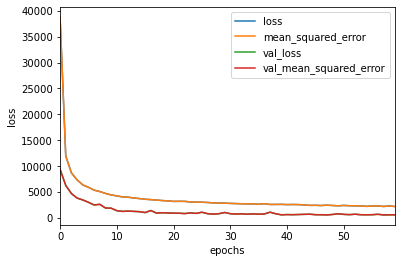

In [44]:
# Plot History
pd.DataFrame(history_m1.history).plot()
plt.ylabel('loss')
plt.xlabel('epochs')

In [45]:
model_1.evaluate(x_test, y_test, verbose=1)

15360/15360 [==============================] - 2s 136us/sample - loss: 539.6369 - mean_squared_error: 539.6371


[539.6368691166242, 539.63715]

In [46]:
test_predict = model_1.predict(x_test)

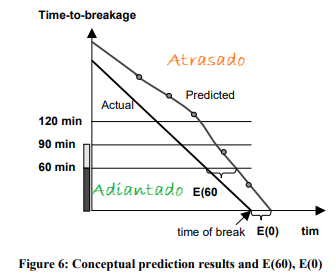

https://www.aaai.org/Papers/Symposia/Spring/2002/SS-02-03/SS02-03-012.pdf

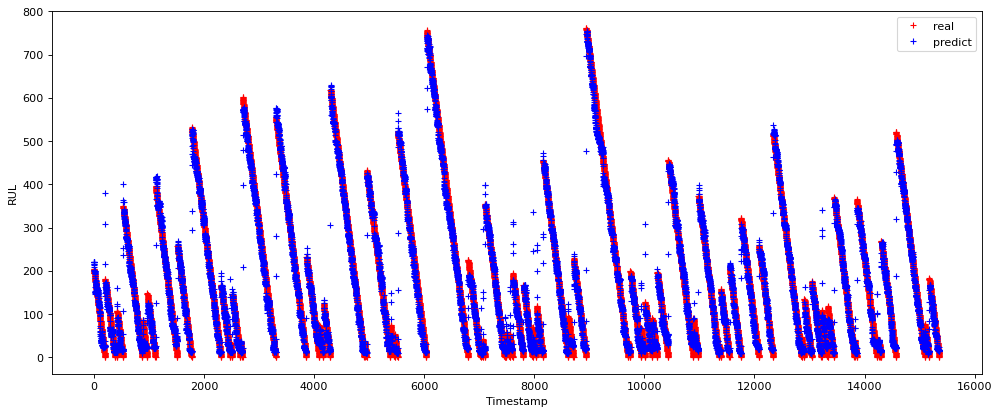

In [47]:
figure(figsize=(15, 6), dpi=80)
plt.xlabel('Timestamp')
plt.ylabel('RUL')
plt.plot(y_test,'r+',label="real")
plt.plot(test_predict,'b+',label="predict")
plt.legend(['real', 'predict'], loc='upper right')

In [48]:
results = pd.DataFrame(y_test)
results['preds']=test_predict
results.columns=['true','preds']
results['dif']=round(results['true']-results['preds'],2)
results.to_csv('results.csv')

In [49]:
results.describe()

,true,preds,dif
count,15360.000000,15360.000000,15360.000000
mean,189.398893,183.051941,6.346973
std,163.002200,161.950500,22.346955
min,0.000000,8.044836,-266.790000
25%,58.000000,44.732941,-2.820000
50%,142.000000,138.431816,6.520000
75%,286.000000,281.654289,14.422500
max,762.000000,755.045959,677.420000


In [50]:
x_train.shape

(35848, 5, 40)

## Análise do Erro

In [51]:
import math
errordf = pd.DataFrame(y_test,columns=['real'])
errordf['pred']=test_predict
errordf['rul_diff']=(errordf['real']-errordf['pred'])
errordf['rul_diff']= errordf['rul_diff'].astype('float')
rul_error_mean = errordf['rul_diff'].sum()/len(errordf['rul_diff'])
rul_error_ahead = np.mean(errordf['rul_diff'].loc[errordf['rul_diff']<0])
rul_error_behind = np.mean(errordf['rul_diff'].loc[errordf['rul_diff']>0])
print ('Erro RUL médio: ',rul_error_mean, '\nErro RUL adiantado: ',rul_error_ahead, '\nErro RUL atrasado: ',rul_error_behind)

Erro RUL médio:  6.346950481086969 
Erro RUL adiantado:  -10.8606675739157 
Erro RUL atrasado:  14.152014675051936


In [43]:
errordf.loc[(errordf['rul_diff'] <= 1) & (errordf['rul_diff'] >= -1)]

NameError: name 'rul_diff_mean' is not defined

### Nos dados de testes existem 64 instantes de quebra de papel

In [ ]:
np.unique(y_test==0,return_counts=True)

In [ ]:
len(errordf.loc[errordf['real']==0])

### Previsões corretas de quebra 

In [ ]:
len(errordf.loc[errordf['pred']==0])

In [ ]:
measurements=0
errordf.loc[(errordf['real'] <= measurements) & (errordf['pred'] <= measurements) ]

### Previsões corretas de quebra dentro de intervalos de tempo

In [ ]:
# 30 medições equivalem a 60 minutos (2 minutos por medição)
measurements=30
len (errordf.loc[(errordf['real'] == 0) & (errordf['pred'] <= measurements) ])

In [ ]:
# 60 medições equivalem a 120 minutos (2 minutos por medição)
measurements=60
len (errordf.loc[(errordf['real'] == 0) & (errordf['pred'] <= measurements) ])

In [ ]:
# 90 medições equivalem a 180 minutos (2 minutos por medição)
measurements=90
len (errordf.loc[(errordf['real'] == 0) & (errordf['pred'] <= measurements) ])

### Porém o modelo estaria avisando falsamente:

In [ ]:
measurements=30
len(errordf.loc[(errordf['real'] > measurements) & (errordf['pred'] <= measurements)])

In [ ]:
measurements=60
len(errordf.loc[(errordf['real'] > measurements) & (errordf['pred'] <= measurements)])

In [ ]:
measurements=90
len(errordf.loc[(errordf['real'] > measurements) & (errordf['pred'] <= measurements)])

## Truth

### Quantas quebras realmente ocorreram?

In [ ]:
# Registro de quebras são aqueles onde RUL==0 (y_test==0)
np.unique(y_test==0,return_counts=True)

### Quando ocorreram?

In [ ]:
break_moments= np.where(y_test == 0)

In [ ]:
list(break_moments)

## Previsões

### Quantas indicações abaixo de x minutos? 

In [ ]:
np.unique(test_predict <= measurements ,return_counts=True)

### Quando ocorreram?

In [ ]:
np.where(test_predict <= measurements)[0]

## Acertos
### Quantos e quando?

In [ ]:
when_pred = np.where(test_predict <= measurements)[0].tolist()
when_true = np.where(y_test == 0)[0].tolist()

In [ ]:
commonalities = set(when_pred) - (set(when_pred) - set(when_true))

In [ ]:
len(commonalities)

In [ ]:
commonalities

In [ ]:
import shap  # package used to calculate Shap values

# use Deep SHAP to explain test set predictions
#k_explainer = shap.KernelExplainer(model_1.predict_proba, x_test)
#k_shap_values = k_explainer.shap_values(x_test.reshape(14315*30,32))
#shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], x_test)

# Salvando o modelo

In [ ]:
model_1.save('../data/pwb_regression-5stps-noavalanche-pca40-batchnormal-bidir')